In [1]:
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import WCSAxes
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.visualization.wcsaxes.frame import EllipticalFrame
import pywt
import numpy
import math
from scipy.stats import poisson
from scipy.stats import ncx2
from scipy.stats import skellam
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import dask.array as dask
import os
from rpy2.robjects import numpy2ri
numpy2ri.activate()

stats = importr("stats")
#utils = importr('utils')
#utils.install_packages("skellam", repo="http://cran.r-project.org", dep=True)
skel = importr("skellam")

os.system("taskset -p 0xff %d" % os.getpid())

pid 10394's current affinity mask: ff
pid 10394's new affinity mask: ff


0

In [2]:
data_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_ccube.fits')
cmap_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_cmap.fits')
model_file = get_pkg_data_filename('allsky_counts_model.fits')
model2_file = get_pkg_data_filename('allsky_counts_model2.fits')
diffuse_file = get_pkg_data_filename('diffuse_only.fits')
point_file = get_pkg_data_filename('point_only.fits')
exp_file = get_pkg_data_filename('lat_source_zmax90_gt1gev_expcube1.fits')

In [3]:
data_hdu = fits.open(data_file)[0]
cmap_hdu = fits.open(cmap_file)[0]
model_hdu = fits.open(model_file)[2]
exp_hdu = fits.open(exp_file)[0]

In [4]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [5]:
plt.rcParams['figure.dpi'] = 300

In [6]:
count_data = fits.getdata(data_file, ext=0)[0]
cmap_data = fits.getdata(cmap_file, ext=0)
count_model = fits.getdata(model_file, ext=0)
count_model2 = fits.getdata(model2_file, ext=0)[0]
#model_data = numpy.vectorize(poisson.rvs)(model_expected)
diffuse_data = fits.getdata(diffuse_file, ext=0)
point_data = fits.getdata(point_file, ext=0)
exp_data = fits.getdata(exp_file, ext=0)[1]
#model_norm = model_data - numpy.min(model_data)

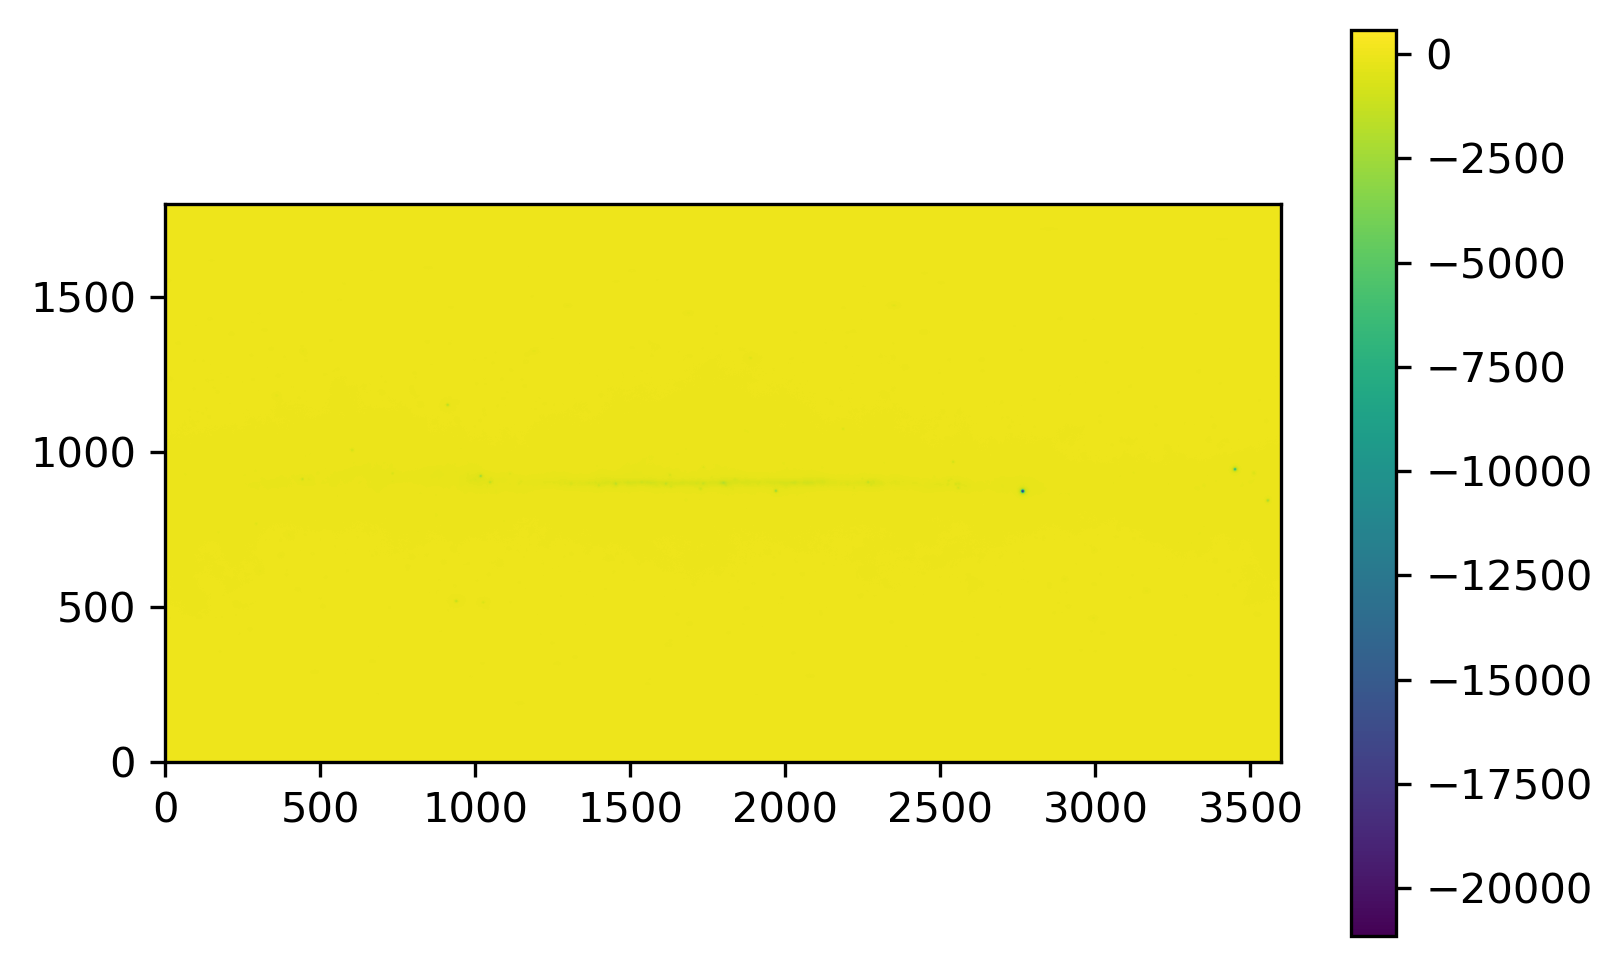

In [49]:
diff = plt.imshow(numpy.subtract(count_data, model_data), origin='lower', cmap=plt.cm.viridis)
#diff = plt.imshow(model_data, origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [8]:
print(numpy.max(count_data), numpy.max(model_data))
print(numpy.min(count_data), numpy.min(model_data))
print(numpy.mean(count_data), numpy.mean(model_data))
print(numpy.max(model_norm), numpy.min(model_norm))
print(numpy.max(exp_data))

32031 48166.207
0 0.0016366403
5.025956790123457 20.96125
48166.207 0.0
715351100000.0


In [7]:
def roll_sphere(arr, lat_roll, lon_roll):
    rows, cols = arr.shape
    #rolled = numpy.empty(arr.shape)
    #for row in range(rows):
    #    rolled[row,:] = sphere_row(numpy.roll(arr, lon_roll, 1), row - lat_roll)
    rolled = numpy.roll(arr, lon_roll, 1)
    rolled = numpy.roll(rolled, lat_roll, 0)
    return rolled

In [8]:
def spherify(arr):
    rows, cols = arr.shape
    spharr = numpy.vstack((arr, numpy.flipud(numpy.roll(arr, cols // 2, 1))))
    return spharr

def unspherify(spharr):
    rows, cols = spharr.shape
    return spharr[0:rows//2, :]

def haar_vals(J, j, arr):
    s = 2**(J - j - 1)
    xx = arr
    xr = roll_sphere(arr, 0, s)
    dx = roll_sphere(arr, s, 0)
    dr = roll_sphere(arr, s, s)
    return (xx, xr, dx, dr)

In [9]:
def haar_sums_j(J, j, arr):
    xx, xr, dx, dr = haar_vals(J, j, arr)
    h1 = numpy.add(xx, dx)
    h2 = numpy.add(xr, dr)
    v1 = numpy.add(xx, xr)
    v2 = numpy.add(dx, dr)
    d1 = numpy.add(xx, dr)
    d2 = numpy.add(xr, dx)
    return ((h1, h2), (v1, v2), (d1, d2))

def haar_1(sums):
    (h1, h2), (v1, v2), (d1, d2) = sums
    a = numpy.add(h1, h2) / 2
    h = numpy.subtract(h1, h2) / 2
    v = numpy.subtract(v1, v2) / 2
    d = numpy.subtract(d1, d2) / 2
    return (a, h, v, d)

def haar(arr, jmin=0):
    a = spherify(arr)
    rows, cols = a.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    hs = []
    vs = []
    ds = []
    for j in range(J-1, jmin-1, -1):
        sums = haar_sums_j(J, j, a)
        a, h, v, d = haar_1(sums)
        hs.append(h)
        vs.append(v)
        ds.append(d)
    return a, hs, vs, ds


In [10]:
#cdf_vec = numpy.vectorize(ncx2.cdf)
#sf_vec = numpy.vectorize(ncx2.sf)
def cdf(x, df, nc):
    return stats.pchisq(x, df, nc)
def sf(x, df, nc):
    return 1 - cdf(x, df, nc)
cdf_vec = numpy.vectorize(cdf)
sf_vec = numpy.vectorize(sf)
#cdf_vec = dask.gufunc(cdf, signature="(i),(j),(i)->(i)", output_dtypes=[float], vectorize=True)
#sf_vec = dask.gufunc(sf, signature="(i),(i),(i)->(i)", output_dtypes=[float], vectorize=True)

def skellam_tail(k, mu1, mu2):
    #print(k)
    #print(mu1)
    #print(mu2)
    p = numpy.ones(k.shape)
    diff_mu = numpy.subtract(mu1, mu2)
    sigma_mu = numpy.sqrt(numpy.add(mu1,mu2))
    large = (mu1 >= 1000) | (mu2 > 1000)
    small = ~large
    left = k <= diff_mu
    right = ~left 
    small_left = small & left
    small_right = small & right
    large_left = large & left
    large_right = large & right
    
    if (p[small_left].size > 0):
        print('small_left')
        p[small_left] = skel.pskellam(k[small_left], mu1[small_left], mu2[small_left], lower_tail=True)
    if (p[small_right].size > 0):
        print('small_right')
        p[small_right] = skel.pskellam(k[small_right], mu1[small_right], mu2[small_right], lower_tail=False)
    if (p[large_left].size > 0):
        print('large_left')
        p[large_left] = stats.pnorm(k[large_left], diff_mu[large_left], sigma_mu[large_left], lower_tail=True)
    if (p[large_right].size > 0):
        print('large_right')
        p[large_right] = stats.pnorm(k[large_right], diff_mu[large_right], sigma_mu[large_right], lower_tail=False)
    #print(p)
    return p

def poisson_tail(x, mu):
    p = numpy.ones(x.shape)
    left = x <= mu
    right = x > mu
    p[left] = stats.ppois(x[left] ,mu[left])
    p[right] = stats.ppois(x[right], mu[right], lower_tail=False)
    return p


In [11]:
def haar_threshold(counts, model, alpha, jmin=0, fwer=None):
    a_counts = spherify(counts)
    a_model = spherify(model)
    rows, cols = a_counts.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    hs = []
    vs = []
    ds = []
    for j in range(J-1, jmin-1, -1):
        f = 2**(J - j - 1)
        print(J, j, f, "******************************")
        if (fwer == 'sidak'):
            alpha_j = 1 - (1 - alpha)**(1/(2**(2*j))) #alpha/(2**(2*j)) 
        elif (fwer == 'bonferroni'):
            alpha_j = alpha/2**(2*j)
        else:
            alpha_j = alpha
        print(alpha_j)
        print("sums")
        sums_counts = haar_sums_j(J, j, a_counts)
        a_counts, h_counts, v_counts, d_counts = haar_1(sums_counts)
        sums_model = haar_sums_j(J, j, a_model)
        a_model, h_model, v_model, d_model = haar_1(sums_model)
        (h1, h2), (v1, v2), (d1, d2) = sums_model
        
        print("h threshold")
        hp = skellam_tail(2*f*h_counts, f*h1, f*h2) 
        h_mask = hp < alpha_j/2
        h_model[h_mask] = h_counts[h_mask]
        
        print("v threshold")
        vp = skellam_tail(2*f*v_counts, f*v1, f*v2) 
        v_mask = vp < alpha_j/2
        v_model[v_mask] = v_counts[v_mask]
        
        print("d threshold")
        dp = skellam_tail(2*f*d_counts, f*d1, f*d2)
        d_mask = dp < alpha_j/2
        d_model[d_mask] = d_counts[d_mask]
        
        hs.append(h_model)
        vs.append(v_model)
        ds.append(d_model)
        print(j, "-> Rejected", h_model[h_mask].size, v_model[v_mask].size, d_model[d_mask].size)
    ap = poisson_tail(2*f*a_counts, 2*f*a_model)
    a_mask = ap < alpha_j/2
    ar = a_counts[a_mask]
    a_model[a_mask] = ar
    #a_model = a_counts
    print("Approximation rejected:", ar.size)
    return a_model, hs, vs, ds

In [12]:
def inv_haar_j(J, j, a, h, v, d):
    N = 2**J
    s = 2**(J - j - 1)
    rows, cols = a.shape
    sh = (rows, cols)
    arr = numpy.empty(sh, float)
    ah = numpy.add(a,h)
    av = numpy.add(a,v)
    ad = numpy.add(a,d)
    vd = numpy.add(v,d)
    hd = numpy.add(h,d)
    hv = numpy.add(h,v)
    xx = numpy.add(ah,vd)
    xr = numpy.subtract(av,hd)
    dx = numpy.subtract(ah,vd)
    dr = numpy.subtract(ad,hv)
    spharr = (xx 
            + roll_sphere(xr, 0, -s) 
            + roll_sphere(dx, -s, 0) 
            + roll_sphere(dr, -s, -s)
           ) / 8
    return spharr

def inv_haar(a, hs, vs, ds):
    rows, cols = a.shape
    J = int(math.ceil(math.log(max(rows, cols), 2)))
    nj = len(hs)
    for i in range(nj-1, -1, -1):
        j = J - i - 1
        a = inv_haar_j(J, j, a, hs[i], vs[i], ds[i])
    return unspherify(a)

In [13]:
def zero(n):
    return numpy.zeros((n,n), float)

def checkers(n, p):
    arr = numpy.zeros((n, 2*n), float) + 2
    for row in range(n):
        rq, rr = divmod(row, p)
        row_mult = 1 if rq % 2 == 0 else -1
        for col in range(2*n):
            cq, cr = divmod(col, p)
            col_mult = 1 if cq % 2 == 0 else -1
            arr[row,col] += row_mult*col_mult
    return arr

def delta(n, row, col):
    arr = numpy.zeros((n, 2*n), float) 
    arr[row, col] = 1
    return arr

def stripe(n, rows):
    arr = numpy.zeros((n, 2*n), float) 
    arr[rows, :] = 1
    return arr

In [595]:
#count_model = stripe(30, [13,14,15])*10 + 1
#data_model = 0.225*count_model #+ stripe(30, [13,14,15])*10 #+ 20*delta(30, 15, 15)
#count_data = poisson.rvs(data_model)
#a_model, hs_model, vs_model, ds_model = haar(count_model)
#a_data, hs_data, vs_data, ds_data = haar(count_data)

In [14]:
a, hs, vs, ds = haar_threshold(count_data, 0.225*count_model, 0.001, fwer='bonferroni')
#a, hs, vs, ds = haar_threshold(count_data, count_model, 0.1)

12 11 1 ******************************
2.384185791015625e-10
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
11 -> Rejected 2930 4084 659
12 10 2 ******************************
9.5367431640625e-10
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
10 -> Rejected 19312 25785 8986
12 9 4 ******************************
3.814697265625e-09
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
small_left
small_right
large_left
large_right
9 -> Rejected 82080 109256 58612
12 8 8 ******************************
1.52587890625e-08
sums
h threshold
small_left
small_right
large_left
large_right
v threshold
small_left
small_right
large_left
large_right
d threshold
sma

In [15]:
count_rec = inv_haar(a, hs, vs, ds)
print(sum(sum(count_data)), sum(sum(0.225*count_model)), sum(sum(count_rec)))

32568200 30561499.922851562 32568201.579101562


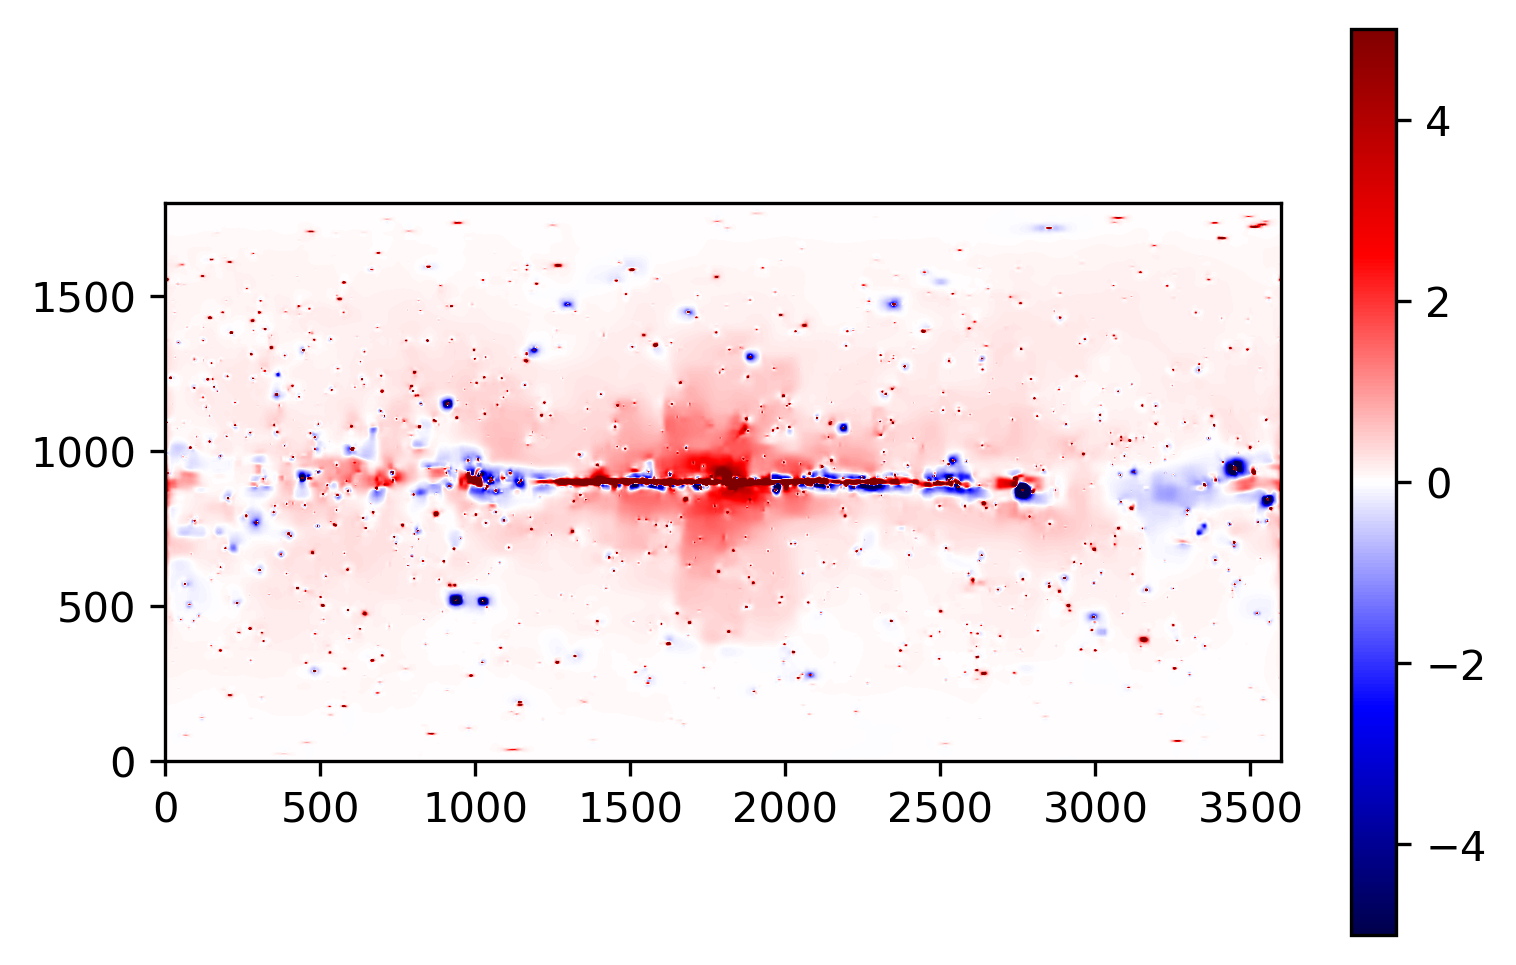

In [16]:
fig, ax = plt.subplots()
foo = plt.imshow(numpy.subtract(count_rec, 0.225*count_model), cmap=plt.cm.seismic, origin='lower', norm=colors.Normalize(vmin=-5,vmax=5))
#foo = plt.imshow(count_model[500:1300,1400:2200], origin='lower', cmap=plt.cm.magma, norm=colors.LogNorm(vmax=1000))
#foo = plt.imshow(count_rec, origin='lower', cmap=plt.cm.magma)
#foo = plt.imshow(numpy.subtract(count_model, count_model2), origin='lower', cmap=plt.cm.magma)
#foo = plt.imshow(vs[0], origin='lower', cmap=plt.cm.magma)
#foo = plt.imshow(numpy.subtract(count_rec, count_model), cmap=plt.cm.magma, origin='lower')
plt.colorbar(foo)
#plt.plot(numpy.subtract(count_data, count_rec)[0, :])

In [17]:
fig.savefig("2021-12-26_1_500_GeV_bonferroni_001.png")

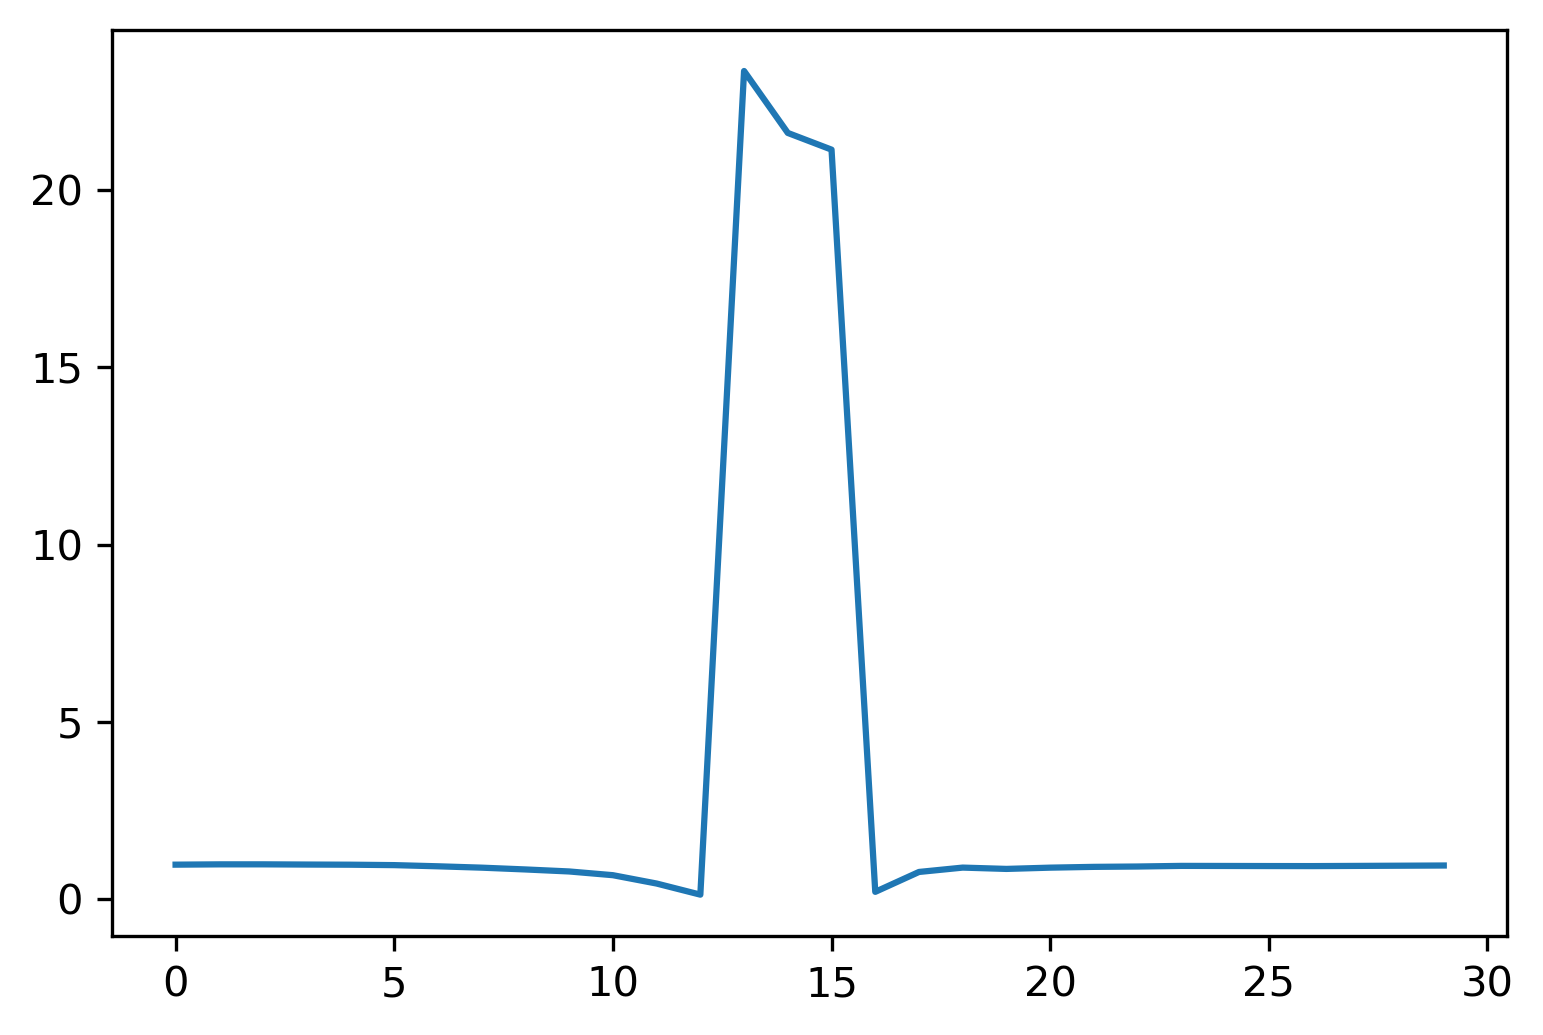

In [538]:
#plt.plot(numpy.subtract(count_rec, 0.225*count_model)[:, 1700])
plt.plot(count_rec[:, 15])

In [546]:
numpy.savez_compressed("2021-12-26_uniform.npz", a=a,hs=hs,vs=vs,ds=ds)

In [637]:
del a, hs, vs, ds

In [62]:
print(sum(sum(count_data)))
print(sum(sum(a)))
print(sum(sum(a2)))
print(sum(sum(a_rec)))
print(sum(sum(count_rec)))
sum(sum(a))/sum(sum(count_data))

32568200
65136400.0
130272792.0
65136396.0
32568200.0


2.0

In [418]:
#foo = plt.imshow(roll_sphere(dx, -1, 0), origin='lower')
#plt.colorbar(foo)
roll_sphere(roll_sphere(im, 1, 0), -1, 0)

1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0
9 0 9 0 0
10 1 0 9 5
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
9 0 9 0 -4
0 0 0 9 0
1 0 1 8 0
2 0 2 7 0
3 0 3 6 0
4 0 4 5 0
5 0 5 4 0
6 0 6 3 0
7 0 7 2 0
8 0 8 1 0


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [188]:
a, h, v, d = haar_j(12, 11, count_data)

In [192]:
a10, _, _, _ = haar_j(12, 10, a)
a9, _, _, _ = haar_j(12, 9, a10)
a8, _, _, _ = haar_j(12, 8, a9)
a7, _, _, _ = haar_j(12, 7, a8)
a6, _, _, _ = haar_j(12, 6, a7)
a5, _, _, _ = haar_j(12, 5, a6)
a4, _, _, _ = haar_j(12, 4, a5)
a3, _, _, _ = haar_j(12, 3, a4)
a2, _, _, _ = haar_j(12, 2, a3)
a1, _, _, _ = haar_j(12, 1, a2)

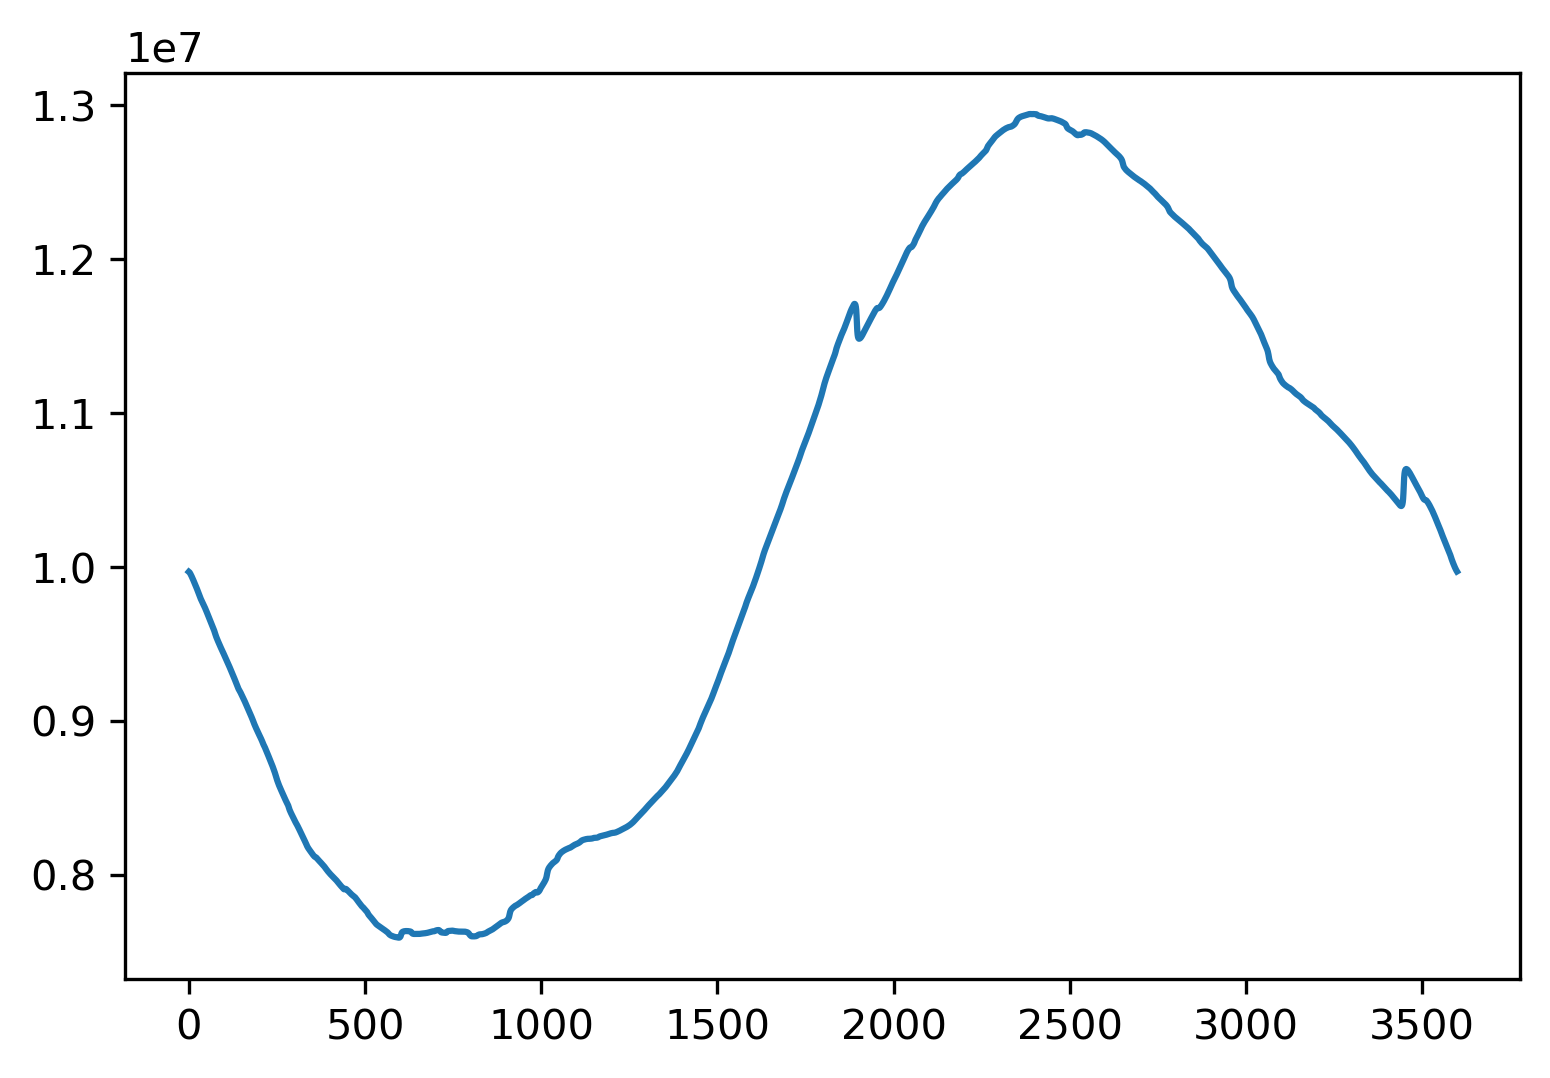

In [194]:
plt.plot(a1[900, :])

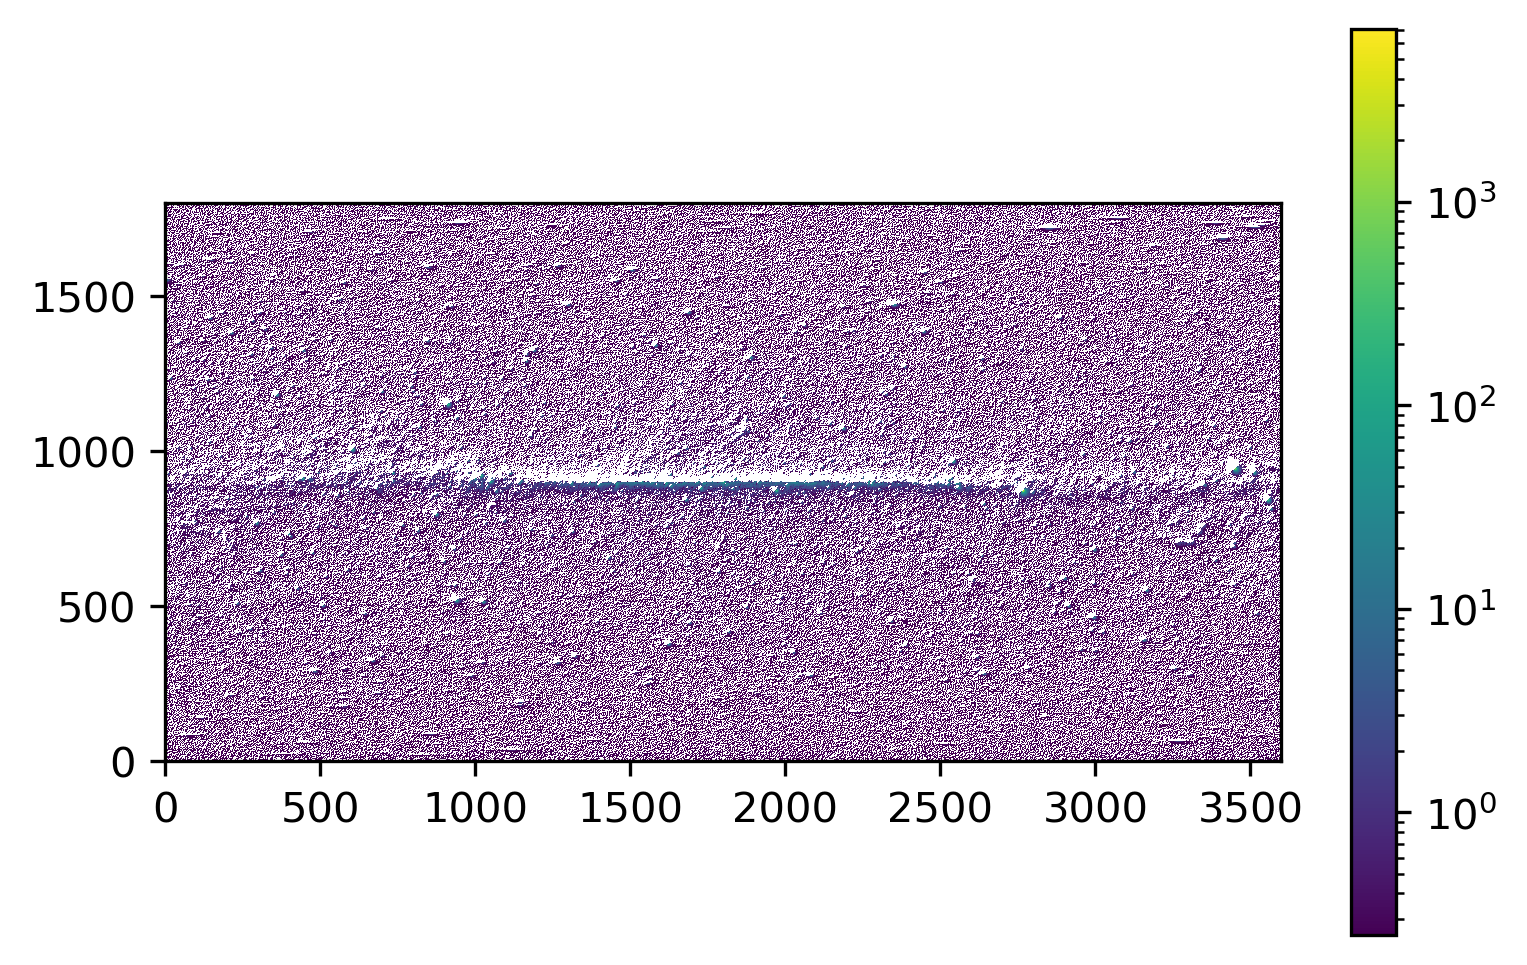

In [215]:
diff = plt.imshow(numpy.subtract(a / 4, count_data), origin='lower', cmap=plt.cm.viridis, norm=colors.LogNorm())
plt.colorbar(diff)

In [109]:
2**12

4096

In [16]:
ax.set_xlim(-180,180)

(-180.0, 180.0)

In [17]:
overlay = ax.get_coords_overlay('fk5')

In [18]:
overlay.grid(color='black', ls='dotted')